In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import *

import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint,EarlyStopping 
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Подлкючаем модуль TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

# красивый Progress_board
from tqdm import tqdm_notebook

import time

from sklearn.preprocessing import MinMaxScaler

In [2]:
# была измененен кодек т.к. через utf-8 выдавалась ошибка 

path = 'C:/Users/user/Desktop/Employers/ServiceSoft(СофтИнжиниринг)/2_Для практического задания/'

s = pd.read_csv(path + '4056_Nd данные для обучения.csv', squeeze=True, encoding = "ISO-8859-1" )

v_d = pd.read_csv(path + '4056_Nd_входящие данные дневные.csv', squeeze=True, encoding = "ISO-8859-1" )

v_n = pd.read_csv(path + '4056_Nd_входящие данные ночные.csv', squeeze=True, encoding = "ISO-8859-1" )

In [3]:
print(s.columns)
print(v_d.columns)
print(v_n.columns)

s_value  = s['Value|Ìàêñèìóì'].values
vd_value = v_d['Value'].values
vn_value = v_n['Value'].values

print(s_value.shape)
print(vd_value.shape)
print(vn_value.shape)

Index(['TimeValue', 'Value|Ìàêñèìóì'], dtype='object')
Index(['TimeValue', 'Value'], dtype='object')
Index(['TimeValue', 'Value'], dtype='object')
(896770,)
(1349,)
(1402,)


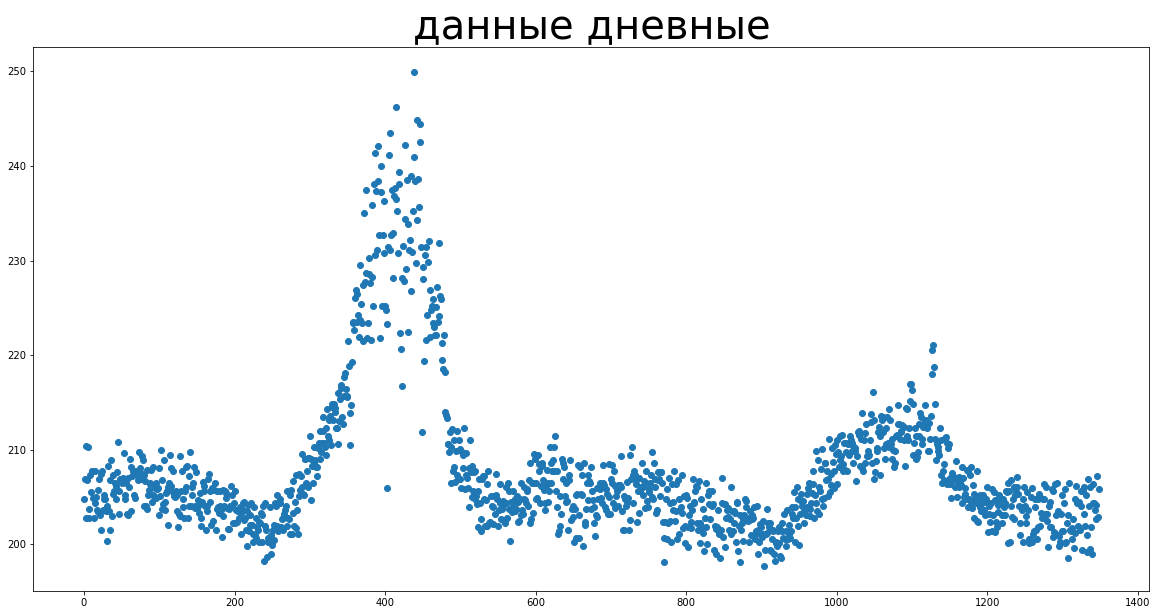

In [4]:
plt.figure(figsize=(20,10))
plt.title('данные дневные', fontsize=40)
plt.scatter(x=range(1349), y=vd_value[:1349]) 

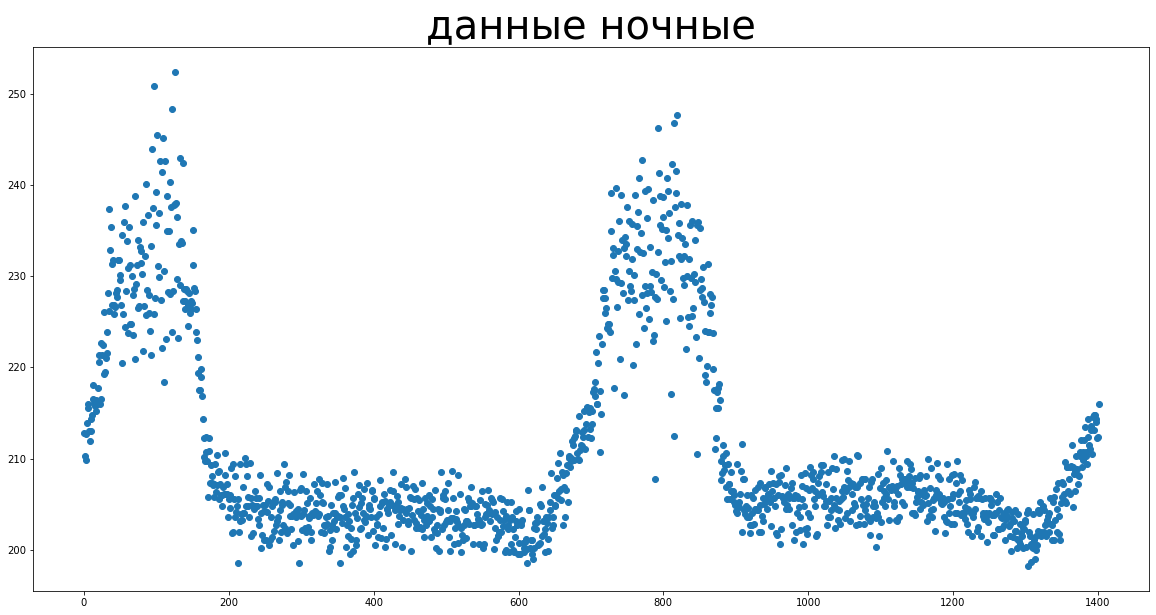

In [5]:
plt.figure(figsize=(20,10))
plt.title('данные ночные', fontsize=40)
plt.scatter(x=range(1402), y=vn_value[:1402]) 

# Основная обработка

In [6]:
v_d.isna().sum()

TimeValue    0
Value        0
dtype: int64

In [7]:
v_d[v_d['Value'] == 0].value_counts

<bound method DataFrame.value_counts of Empty DataFrame
Columns: [TimeValue, Value]
Index: []>

In [8]:
v_n.isna().sum()

TimeValue    0
Value        0
dtype: int64

In [9]:
v_n[v_n['Value'] == 0].value_counts

<bound method DataFrame.value_counts of Empty DataFrame
Columns: [TimeValue, Value]
Index: []>

In [10]:
mask = (s['Value|Ìàêñèìóì'] != 0)
s = s[mask]
s.shape

(818707, 2)

In [11]:
##########################################################################################
# Конвертируем TimeValue в тип Timestamp и делаем его индексным сталбцом исходной таблицы.
##########################################################################################

t1 = time.time()
v_d.index = pd.to_datetime(v_d.TimeValue, dayfirst=True)
print(time.time() - t1)

t1 = time.time()
v_n.index = pd.to_datetime(v_n.TimeValue, dayfirst=True)
print(time.time() - t1)

t1 = time.time()
s_10 = s.iloc[:200000]
s_10.index = pd.to_datetime(s_10.TimeValue, dayfirst=True)
s_10.rename(columns={'Value|Ìàêñèìóì': 'Value'}, inplace=True)
print(time.time() - t1)

0.3252437114715576
0.24000835418701172
28.650017023086548


In [12]:
s_samp = s.iloc[:1]
s_samp.index = pd.to_datetime(s_samp.TimeValue, dayfirst=True)
s_samp.rename(columns={'Value|Ìàêñèìóì': 'Value'}, inplace=True)

s_samp = s_samp.iloc[:1]     # "Откусываем" пример длинной xLen
s_samp = s_samp.Value.resample('s').interpolate()

s_samp # исполбзуется в create_samples

TimeValue
2019-03-01 00:00:09    194.281464
Freq: S, Name: Value, dtype: float64

In [13]:
########################################################
# Функция интерполяции всего массива значений по частям.
########################################################

def create_samples(data, xLen, step):
           
    data_len = data.iloc[:].shape[0]
    index = 0            
    count = 0
    
    
    batch_sum = s_samp   # берём шаблон для конкатинации Serias объектов
    
    while (index + xLen <= data_len):          # Идём по всей длине массива значений
        t1 = time.time()
        
        batch = data.iloc[index:index+xLen]     # "Откусываем" пример длинной xLen
      
        batch = batch.Value.resample('s').interpolate().resample('4T').interpolate().resample('1T').interpolate()
               
        batch = batch.dropna()
     
        now_shape = batch.shape[0]
     
        count += now_shape
        
        batch_sum = pd.concat([batch_sum, batch])
        
        index += step                          # Смещаеммся вперёд на step
        
        if index % step == 0:
            print(index, time.time()-t1)
            
    print(count)
    
    return batch_sum

In [14]:
batch_sum = create_samples(s_10, 1000, 1000)

1000 0.16958403587341309
2000 0.025990009307861328
3000 0.026986360549926758
4000 0.026981830596923828
5000 0.02698540687561035
6000 0.026983976364135742
7000 0.0259854793548584
8000 0.02698493003845215
9000 0.04197502136230469
10000 0.028983592987060547
11000 0.032979726791381836
12000 0.027013063430786133
13000 0.02797985076904297
14000 0.026199817657470703
15000 0.0279848575592041
16000 0.0279848575592041
17000 0.03397798538208008
18000 0.03098440170288086
19000 0.027360916137695312
20000 0.02698493003845215
21000 0.026984453201293945
22000 0.026983976364135742
23000 0.026985645294189453
24000 0.028986454010009766
25000 0.032979726791381836
26000 0.028981447219848633
27000 0.028005361557006836
28000 0.027985095977783203
29000 0.027984142303466797
30000 0.026371479034423828
31000 0.02598404884338379
32000 0.027983665466308594
33000 0.03498220443725586
34000 0.03198361396789551
35000 0.028000593185424805
36000 0.026474714279174805
37000 0.026984691619873047
38000 0.026984214782714844


In [194]:
# данные интерполируются поминутно по индексу
res_d = v_d.Value.resample('s').interpolate().resample('1T').asfreq().dropna()

res_n = v_n.Value.resample('s').interpolate().resample('1T').asfreq().dropna()

In [195]:
t1 = time.time()

s_10 = s.iloc[:105000]
s_10.index = pd.to_datetime(s_10.TimeValue, dayfirst=True)
s_10.rename(columns={'Value|Ìàêñèìóì': 'Value'}, inplace=True)

print(time.time() - t1)

13.290395736694336


In [196]:
batch_sum

TimeValue
2019-03-01 00:00:09    194.281464
2019-03-01 00:04:00    186.461330
2019-03-01 00:05:00    186.821789
2019-03-01 00:06:00    187.182248
2019-03-01 00:07:00    187.542708
                          ...    
2019-11-24 16:08:00    184.727026
2019-11-24 16:09:00    184.940660
2019-11-24 16:10:00    185.154295
2019-11-24 16:11:00    185.367930
2019-11-24 16:12:00    185.581564
Name: Value, Length: 386121, dtype: float64

In [197]:
res = batch_sum.to_frame()
res_v = batch_sum.values

Scaler = MinMaxScaler()
res_v = Scaler.fit_transform(res_v.reshape(-1,1))
res.Value = res_v
res_v = res_v.reshape(res_v.shape[0])

In [198]:
res_v

array([0.4564126 , 0.16430853, 0.17777271, ..., 0.11548711, 0.12346697,
       0.13144683])

In [199]:
buf1 = res_d
res_d = res_d.to_frame()

#Scaler_d = MinMaxScaler()

res_dv = buf1.values
res_dv = Scaler.transform(res_dv.reshape(-1,1))
res_d.Value = res_dv
res_dv = res_dv.reshape(res_dv.shape[0])

In [200]:
res_dv

array([0.86941623, 0.89343479, 0.91745334, ..., 0.7896772 , 0.83935542,
       0.88903363])

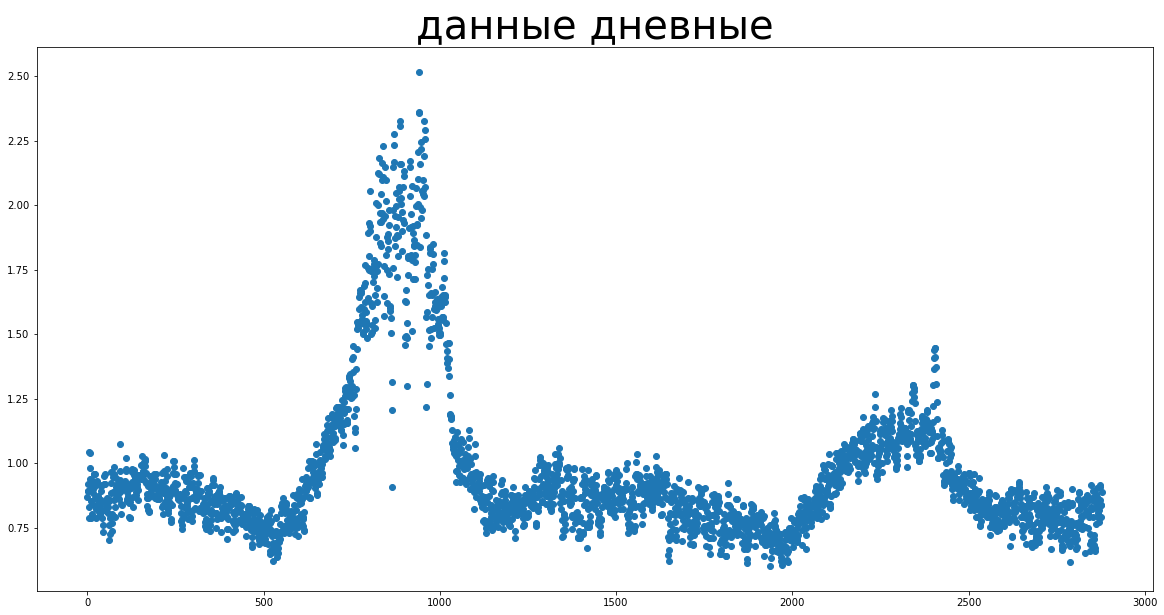

In [201]:
plt.figure(figsize=(20,10))
plt.title('данные дневные', fontsize=40)
plt.scatter(x=range(res_dv.shape[0]), y=res_dv) 

In [202]:
buf1 = res_n
res_n = res_n.to_frame()

#Scaler_n = MinMaxScaler()

res_nv = buf1.values
res_nv = Scaler.transform(res_nv.reshape(-1,1))
res_n.Value = res_nv
res_nv = res_nv.reshape(res_nv.shape[0])

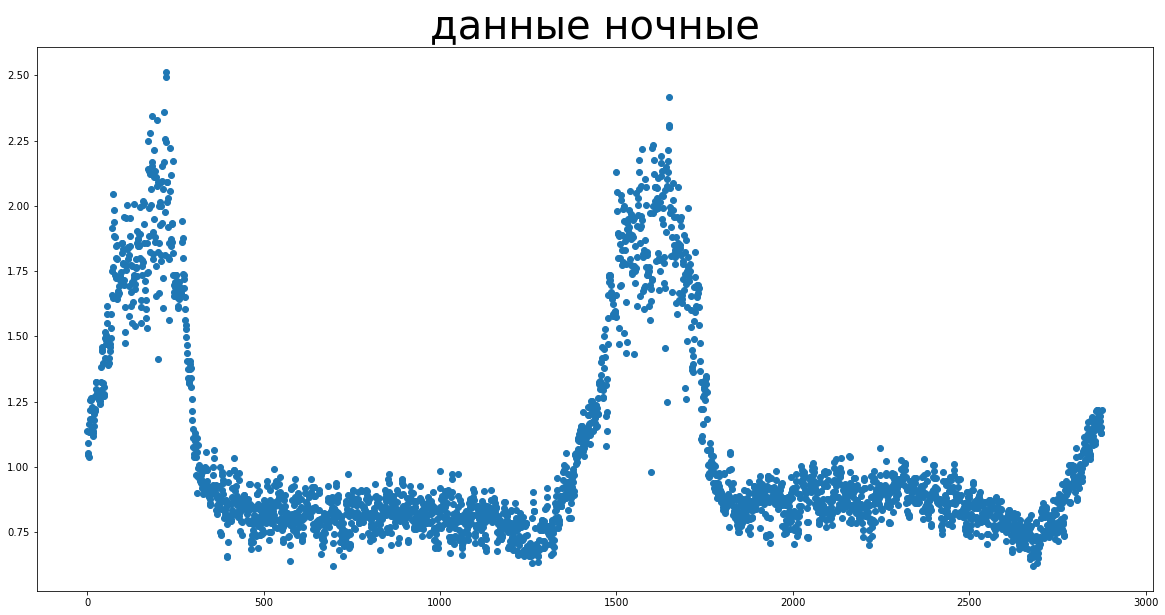

In [203]:
plt.figure(figsize=(20,10))
plt.title('данные ночные', fontsize=40)
plt.scatter(x=range(res_nv.shape[0]), y=res_nv) 

In [204]:
# создание обрабатываемого набора и именование
resedit_d = res_d
resedit_d.Value.name='Minus 0 minut'  # ЗАМЕНИЛ Minus 1440 minut

# создание обрабатываемого набора и именование
resedit_n = res_n
resedit_n.Value.name='Minus 0 minut'  # ЗАМЕНИЛ Minus 1440 minut


In [205]:
resedit_d.Value

TimeValue
2021-08-03 11:57:00    0.869416
2021-08-03 11:58:00    0.893435
2021-08-03 11:59:00    0.917453
2021-08-03 12:00:00    0.890408
2021-08-03 12:01:00    0.829320
                         ...   
2021-08-05 11:51:00    0.913488
2021-08-05 11:52:00    0.839185
2021-08-05 11:53:00    0.789677
2021-08-05 11:54:00    0.839355
2021-08-05 11:55:00    0.889034
Freq: T, Name: Minus 0 minut, Length: 2879, dtype: float64

In [207]:

###################################################
# создание и именование датафрейма скользящим окон.
###################################################

n=20 # шаг

allres=[] # лист из семплов

for i in range(0,73):
    res1 = resedit_d.Value.shift(periods=1440-n*i)   # СДВИГАЕМСЯ ВПЕРЁД
    res1.name = f'{1440-n*i} minutes ago'      # 
    allres.append(res1)

# [1,2,3,4,5] -> [2,3,4,5,Nan] -> [3,4,5,NaN,NaN]...  
    
for i in allres:
    resedit_d = pd.concat([resedit_d,i],axis=1)

#.....................................................................    
    
allres=[] # лист из семплов

for i in range(0,73):
    res1 = resedit_n.Value.shift(periods=1440-n*i)   # СДВИГАЕМСЯ ВПЕРЁД
    res1.name = f'{1440-n*i} minutes ago'     # 
    allres.append(res1)

# [1,2,3,4,5] -> [2,3,4,5,Nan] -> [3,4,5,NaN,NaN]...  
    
for i in allres:
    resedit_n=pd.concat([resedit_n,i],axis=1)   
    


In [208]:
resedit_d.iloc[-5:]

,Value,1440 minutes ago,1420 minutes ago,1400 minutes ago,1380 minutes ago,1360 minutes ago,1340 minutes ago,1320 minutes ago,1300 minutes ago,1280 minutes ago,...,180 minutes ago,160 minutes ago,140 minutes ago,120 minutes ago,100 minutes ago,80 minutes ago,60 minutes ago,40 minutes ago,20 minutes ago,0 minutes ago
TimeValue,,,,,,,,,,,,,,,,,,,,,
2021-08-05 11:51:00,0.913488,0.882522,0.720203,0.863166,0.899630,0.870172,0.727602,0.829720,0.823201,0.840546,...,0.817812,0.842416,0.741989,0.736436,0.722023,0.847345,0.856565,0.808867,0.670928,0.913488
2021-08-05 11:52:00,0.839185,0.917792,0.758098,0.898864,0.848575,0.862789,0.786546,0.951446,0.880613,0.844703,...,0.832508,0.803477,0.816576,0.736315,0.723033,0.759520,0.822302,0.814380,0.683822,0.839185
2021-08-05 11:53:00,0.789677,0.915820,0.784942,0.933368,0.817195,0.873712,0.848769,1.005916,0.841138,0.912653,...,0.846688,0.779543,0.783635,0.772402,0.733200,0.725963,0.777076,0.863322,0.723009,0.789677
2021-08-05 11:54:00,0.839355,0.911187,0.781397,0.967179,0.792048,0.876672,0.810367,0.959505,0.800020,0.951107,...,0.798131,0.815635,0.743015,0.821028,0.784165,0.723823,0.750152,0.875512,0.707656,0.839355
2021-08-05 11:55:00,0.889034,0.870100,0.780530,0.963306,0.854181,0.847778,0.746810,0.959778,0.844103,0.930574,...,0.738503,0.851008,0.778396,0.878015,0.829428,0.725175,0.796433,0.801948,0.660727,0.889034


In [209]:
resedit_n.iloc[-5:]

,Value,1440 minutes ago,1420 minutes ago,1400 minutes ago,1380 minutes ago,1360 minutes ago,1340 minutes ago,1320 minutes ago,1300 minutes ago,1280 minutes ago,...,180 minutes ago,160 minutes ago,140 minutes ago,120 minutes ago,100 minutes ago,80 minutes ago,60 minutes ago,40 minutes ago,20 minutes ago,0 minutes ago
TimeValue,,,,,,,,,,,,,,,,,,,,,
2021-08-03 23:55:00,1.144853,1.171649,1.329899,1.137843,1.576724,2.024171,1.947913,1.751476,2.216219,1.749153,...,0.660183,0.727363,0.809572,0.752866,0.912264,0.935952,0.992774,1.080116,1.118364,1.144853
2021-08-03 23:56:00,1.128825,1.139105,1.315220,1.212301,1.581909,2.041978,1.911790,1.703336,1.945068,1.616307,...,0.634362,0.755592,0.815939,0.788615,0.945791,0.922505,1.043636,1.101712,1.153785,1.128825
2021-08-03 23:57:00,1.129495,1.170760,1.300540,1.336080,1.590095,1.697159,1.875667,1.847638,1.803131,1.697192,...,0.651831,0.807625,0.811676,0.842530,0.918985,0.944621,1.013397,1.124020,1.166649,1.129495
2021-08-03 23:58:00,1.153779,1.202414,1.323340,1.469725,1.595085,1.889977,1.897367,2.050509,1.816145,1.973870,...,0.669741,0.837868,0.775522,0.898464,0.892179,0.967000,0.992323,1.148903,1.173874,1.153779
2021-08-03 23:59:00,1.218852,1.231434,1.352755,1.571553,1.595896,1.830926,1.919068,1.761701,1.673036,1.562859,...,0.696014,0.844820,0.747717,0.870167,0.902594,0.989909,0.979578,1.173787,1.142669,1.218852


In [210]:
resedit_d.drop('Value', axis=1, inplace=True)

resedit_n.drop('Value', axis=1, inplace=True)

In [211]:
# создание дамми-параметров по месяцу и часу
resedit_d.insert(0,'Month',(resedit_d.index + timedelta(minutes=240)).month)
resedit_d.insert(0,'Hour',(resedit_d.index + timedelta(minutes=240)).hour)
resedit_d=pd.get_dummies(resedit_d,columns=['Month'])
resedit_d=pd.get_dummies(resedit_d,columns=['Hour'])

# создание дамми-параметров по месяцу и часу
resedit_n.insert(0,'Month',(resedit_n.index + timedelta(minutes=240)).month)
resedit_n.insert(0,'Hour',(resedit_n.index + timedelta(minutes=240)).hour)
resedit_n=pd.get_dummies(resedit_n,columns=['Month'])
resedit_n=pd.get_dummies(resedit_n,columns=['Hour'])

In [212]:
resedit_d.head()

,1440 minutes ago,1420 minutes ago,1400 minutes ago,1380 minutes ago,1360 minutes ago,1340 minutes ago,1320 minutes ago,1300 minutes ago,1280 minutes ago,1260 minutes ago,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
TimeValue,,,,,,,,,,,,,,,,,,,,,
2021-08-03 11:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
2021-08-03 11:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
2021-08-03 11:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
2021-08-03 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2021-08-03 12:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0


In [213]:
# подгонка под шаблон датафрейма для подачи в сеть 

c1 = []

for i in range(0, 1441, 20):
    c1.append(f'{1440-i} minutes ago' )

for i in range(1, 13, 1):
    c1.append(f'Month_{i}')   

for i in range(24):
    c1.append(f'Hour_{i}')  
    
print(c1)


['1440 minutes ago', '1420 minutes ago', '1400 minutes ago', '1380 minutes ago', '1360 minutes ago', '1340 minutes ago', '1320 minutes ago', '1300 minutes ago', '1280 minutes ago', '1260 minutes ago', '1240 minutes ago', '1220 minutes ago', '1200 minutes ago', '1180 minutes ago', '1160 minutes ago', '1140 minutes ago', '1120 minutes ago', '1100 minutes ago', '1080 minutes ago', '1060 minutes ago', '1040 minutes ago', '1020 minutes ago', '1000 minutes ago', '980 minutes ago', '960 minutes ago', '940 minutes ago', '920 minutes ago', '900 minutes ago', '880 minutes ago', '860 minutes ago', '840 minutes ago', '820 minutes ago', '800 minutes ago', '780 minutes ago', '760 minutes ago', '740 minutes ago', '720 minutes ago', '700 minutes ago', '680 minutes ago', '660 minutes ago', '640 minutes ago', '620 minutes ago', '600 minutes ago', '580 minutes ago', '560 minutes ago', '540 minutes ago', '520 minutes ago', '500 minutes ago', '480 minutes ago', '460 minutes ago', '440 minutes ago', '420 mi

In [214]:
df_ = pd.DataFrame(columns=c1)

In [215]:
df_

,1440 minutes ago,1420 minutes ago,1400 minutes ago,1380 minutes ago,1360 minutes ago,1340 minutes ago,1320 minutes ago,1300 minutes ago,1280 minutes ago,1260 minutes ago,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23


In [216]:

df_ = pd.DataFrame(columns=c1)
frames = [df_, resedit_d]
resedit_d = pd.concat(frames, sort=False)

#....................................................

df_ = pd.DataFrame(columns=c1)
frames = [df_, resedit_n]
resedit_n = pd.concat(frames, sort=False)


In [217]:
res_d = res_d.Value

res_n = res_n.Value

In [218]:
resedit_d.head()

,1440 minutes ago,1420 minutes ago,1400 minutes ago,1380 minutes ago,1360 minutes ago,1340 minutes ago,1320 minutes ago,1300 minutes ago,1280 minutes ago,1260 minutes ago,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
2021-08-03 11:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
2021-08-03 11:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
2021-08-03 11:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
2021-08-03 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2021-08-03 12:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0


In [219]:
res_d

TimeValue
2021-08-03 11:57:00    0.869416
2021-08-03 11:58:00    0.893435
2021-08-03 11:59:00    0.917453
2021-08-03 12:00:00    0.890408
2021-08-03 12:01:00    0.829320
                         ...   
2021-08-05 11:51:00    0.913488
2021-08-05 11:52:00    0.839185
2021-08-05 11:53:00    0.789677
2021-08-05 11:54:00    0.839355
2021-08-05 11:55:00    0.889034
Freq: T, Name: Minus 0 minut, Length: 2879, dtype: float64

In [220]:
# создание колонок меток времени для старта и прогноза
dfopor_d['Data_Time_Start'] = dfopor_d.index + timedelta(minutes=0)
dfopor_d['Data_Time_Prognoz'] = dfopor_d.index + timedelta(minutes=240)

# создание колонок меток времени для старта и прогноза
dfopor_n['Data_Time_Start'] = dfopor_n.index + timedelta(minutes=0)
dfopor_n['Data_Time_Prognoz'] = dfopor_n.index + timedelta(minutes=240)

In [221]:
dfopor_d

,1440 minutes ago,1420 minutes ago,1400 minutes ago,1380 minutes ago,1360 minutes ago,1340 minutes ago,1320 minutes ago,1300 minutes ago,1280 minutes ago,1260 minutes ago,...,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Prognoz 4 hour,Data_Time_Start,Data_Time_Prognoz
2021-08-03 11:57:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,2021-08-03 11:57:00,2021-08-03 15:57:00
2021-08-03 11:58:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,2021-08-03 11:58:00,2021-08-03 15:58:00
2021-08-03 11:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,2021-08-03 11:59:00,2021-08-03 15:59:00
2021-08-03 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,2021-08-03 12:00:00,2021-08-03 16:00:00
2021-08-03 12:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,2021-08-03 12:01:00,2021-08-03 16:01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-05 11:51:00,0.882522,0.720203,0.863166,0.899630,0.870172,0.727602,0.829720,0.823201,0.840546,1.027978,...,0,0,0,0,0,0,0,0.772466,2021-08-05 11:51:00,2021-08-05 15:51:00
2021-08-05 11:52:00,0.917792,0.758098,0.898864,0.848575,0.862789,0.786546,0.951446,0.880613,0.844703,0.963931,...,0,0,0,0,0,0,0,0.826960,2021-08-05 11:52:00,2021-08-05 15:52:00
2021-08-05 11:53:00,0.915820,0.784942,0.933368,0.817195,0.873712,0.848769,1.005916,0.841138,0.912653,0.878438,...,0,0,0,0,0,0,0,0.884627,2021-08-05 11:53:00,2021-08-05 15:53:00
2021-08-05 11:54:00,0.911187,0.781397,0.967179,0.792048,0.876672,0.810367,0.959505,0.800020,0.951107,0.853597,...,0,0,0,0,0,0,0,0.883553,2021-08-05 11:54:00,2021-08-05 15:54:00


In [270]:
dfopor_n

,1440 minutes ago,1420 minutes ago,1400 minutes ago,1380 minutes ago,1360 minutes ago,1340 minutes ago,1320 minutes ago,1300 minutes ago,1280 minutes ago,1260 minutes ago,...,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Prognoz 4 hour,Data_Time_Start,Data_Time_Prognoz
2021-08-02 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,2021-08-02 00:03:00,2021-08-02 04:03:00
2021-08-02 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,2021-08-02 00:04:00,2021-08-02 04:04:00
2021-08-02 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,2021-08-02 00:05:00,2021-08-02 04:05:00
2021-08-02 00:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,2021-08-02 00:06:00,2021-08-02 04:06:00
2021-08-02 00:07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,NaN,2021-08-02 00:07:00,2021-08-02 04:07:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-03 23:55:00,1.171649,1.329899,1.137843,1.576724,2.024171,1.947913,1.751476,2.216219,1.749153,1.790582,...,0,0,0,0,0,0,0,0.757061,2021-08-03 23:55:00,2021-08-04 03:55:00
2021-08-03 23:56:00,1.139105,1.315220,1.212301,1.581909,2.041978,1.911790,1.703336,1.945068,1.616307,1.986939,...,0,0,0,0,0,0,0,0.765457,2021-08-03 23:56:00,2021-08-04 03:56:00
2021-08-03 23:57:00,1.170760,1.300540,1.336080,1.590095,1.697159,1.875667,1.847638,1.803131,1.697192,2.008397,...,0,0,0,0,0,0,0,0.805586,2021-08-03 23:57:00,2021-08-04 03:57:00
2021-08-03 23:58:00,1.202414,1.323340,1.469725,1.595085,1.889977,1.897367,2.050509,1.816145,1.973870,2.029855,...,0,0,0,0,0,0,0,0.819104,2021-08-03 23:58:00,2021-08-04 03:58:00


In [223]:
X_test_sub_d = dfopor_d
X_test_sub_n = dfopor_n

In [224]:
# заполнение пустых дамми-значений
X_test_sub_d=X_test_sub_d.fillna(0)

# заполнение пустых дамми-значений
X_test_sub_n=X_test_sub_n.fillna(0)

In [228]:
# массивы входов и целевой переменной для подачи в сеть
X_d=X_test_sub_d.values[-240:,:109]
print(X_d.shape)

# массивы входов и целевой переменной для подачи в сеть
X_n=X_test_sub_n.values[-240:,:109]
print(X_n.shape)

(240, 109)
(240, 109)


In [231]:
X_d

array([[0.777675536707763, 0.8028207399907039, 0.762323648915249, ..., 0,
        0, 0],
       [0.8139254578450199, 0.8156108769402381, 0.8038851856928799, ...,
        0, 0, 0],
       [0.8469684215777722, 0.8516673972465725, 0.8454467224705118, ...,
        0, 0, 0],
       ...,
       [0.9158199320934921, 0.7849423509296987, 0.933367631350805, ...,
        0, 0, 0],
       [0.9111872358792006, 0.7813970492895228, 0.9671790365628938, ...,
        0, 0, 0],
       [0.8701004171901081, 0.7805296475109271, 0.9633064709229755, ...,
        0, 0, 0]], dtype=object)

In [232]:
X_n

array([[0.7184151868188646, 0.7580691784247753, 0.684047796934868, ...,
        0, 0, 0],
       [0.6885579091959126, 0.7212962529104558, 0.660627834412062, ...,
        0, 0, 0],
       [0.76291954760244, 0.6805925448091195, 0.6811565133439474, ..., 0,
        0, 0],
       ...,
       [1.1707599226834162, 1.300539683994388, 1.3360804597902396, ...,
        0, 0, 0],
       [1.2024143683816844, 1.3233400889806868, 1.4697248171849955, ...,
        0, 0, 0],
       [1.2314342312964106, 1.3527546590532422, 1.5715525666662922, ...,
        0, 0, 0]], dtype=object)

## Modelling

In [233]:
# модель нейросети
X_d = np.asarray(X_d).astype(np.float32)

# модель нейросети
X_n = np.asarray(X_n).astype(np.float32)



In [234]:
input_shape_conv = (109, 1)

def conv_model():

    modelC = Sequential()

    modelC.add(Conv1D(64, 5, input_shape = input_shape_conv, activation="relu"))
    modelC.add(Conv1D(64, 5, activation="relu"))
    modelC.add(MaxPooling1D())
    modelC.add(Flatten())
    modelC.add(Dense(100, activation="relu"))
    modelC.add(Dense(1, activation="linear"))

    # компиляция модели

    modelC.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['log_cosh'])

    modelC.summary()
    
    return modelC



In [235]:
######################################
#  Функция получения метрик и ошибки.
######################################

def show_losses(history):

    # графики обучения
    acc = history.history['log_cosh']
    val_acc = history.history['val_log_cosh']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    


In [249]:
################################
# Функция визуализации графиков.
################################

def showPredict(start, step, channel, predVal):
    '''
        start - точка с которой начинаем отрисовку графика
        step - длина графика, которую отрисовываем
        channel - какой канал отрисовываем  
  
    '''
    
    plt.figure(figsize=(22,6))
    plt.plot(predVal[start:start+step],#, 0],
             label='Прогноз')
#    plt.plot(yValUnscaled[start:start+step],#, channel], 
#             label='Базовый ряд')
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

In [250]:
############################################
# Расчет линейнного коэффициента корреляции.
############################################

def correlate(a, b):

  ma = a.mean() 
  mb = b.mean() 
  mab = (a*b).mean() 
  sa = a.std() 
  sb = b.std() 
  
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

In [251]:
#####################################################################################
# Расчитываем корелляцию между базовым рядом и предсказанным  с разныс сдвигом шагов.
#####################################################################################


def showCorr(channels, corrSteps, predVal, yValUnscaled):

    '''
        channels - по каким каналам отображать корреляцию
        corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции

    '''        
  # Проходим по всем каналам
    for ch in channels:
      corr = [] 
      yLen = yValUnscaled.shape[0] 

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
      for i in range(corrSteps):
        corr.append(correlate(yValUnscaled[:yLen-i], predVal[i:]))   
        own_corr = [] 

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
      for i in range(corrSteps):
        own_corr.append(correlate(yValUnscaled[:yLen-i], yValUnscaled[i:]))  

    # Отображаем график коррелций для данного шага
      plt.figure(figsize=(14,7))
      plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
      plt.plot(own_corr, label='Эталон')

    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

In [252]:
############################################
# Функция отображения необходимых графиков.
############################################


def get_inf(model, window, steps, X, Scaler):
    
    '''
    model - текущая модель
    window - кол-во значений на графике предсказанного временного ряда
    steps - кол-во сдвигов подсчета автокорелляции
    
    '''
#    show_losses(history)
    
    predictions = model.predict(X, verbose=1)
    pred = Scaler.inverse_transform(predictions)
#    y_un = Scaler.inverse_transform(y.reshape(-1,1))
    
    showPredict(0,window,0,pred)
    
    pred = predictions.reshape(predictions.shape[0])
#    showCorr([0], steps, pred, y)
    

In [253]:
############
# Callbacks.
############

def create_call(name_model):
    
    checkpoint = ModelCheckpoint(path + name_model, verbose=1, monitor='val_log_cosh', save_best_only=True, mode='auto')
    earlystop = EarlyStopping(monitor='val_log_cosh', patience=10, restore_best_weights=True)
    callbacks_list = [checkpoint, earlystop]
    
    return callbacks_list

# Дневные

In [254]:
callbacks_list = create_call('model_Day')

In [255]:
model_Day = conv_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 105, 64)           384       
                                                                 
 conv1d_3 (Conv1D)           (None, 101, 64)           20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               320100    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                      

In [256]:
model_Day.load_weights(path + 'model_final_C.hdf5')

8/8 [==============================] - 0s 5ms/step


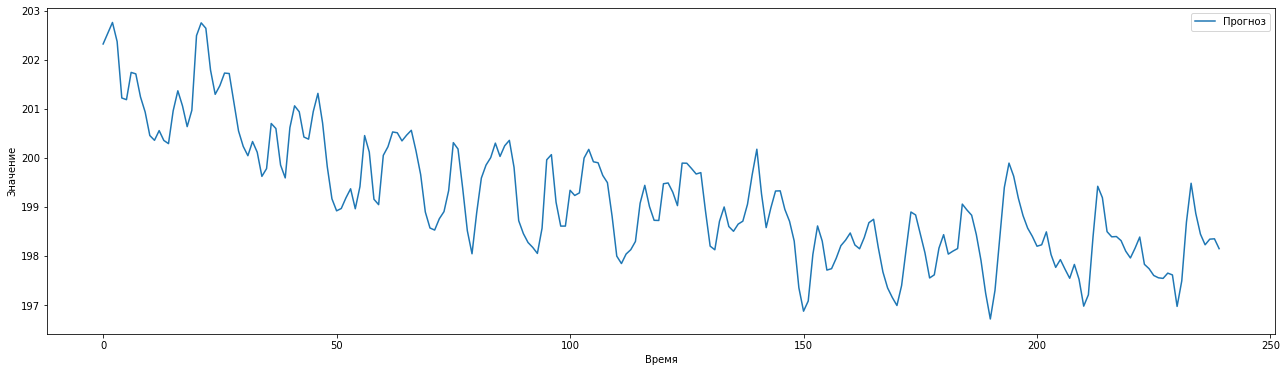

In [257]:
get_inf(model_Day, 3000, 500, X_d, Scaler)

## Ночные

In [258]:
callbacks_list = create_call('model_Night')

In [259]:
model_Night = conv_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 105, 64)           384       
                                                                 
 conv1d_5 (Conv1D)           (None, 101, 64)           20544     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 50, 64)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3200)              0         
                                                                 
 dense_4 (Dense)             (None, 100)               320100    
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                      

In [260]:
model_Night.load_weights(path + 'model_final_C.hdf5')

8/8 [==============================] - 0s 5ms/step


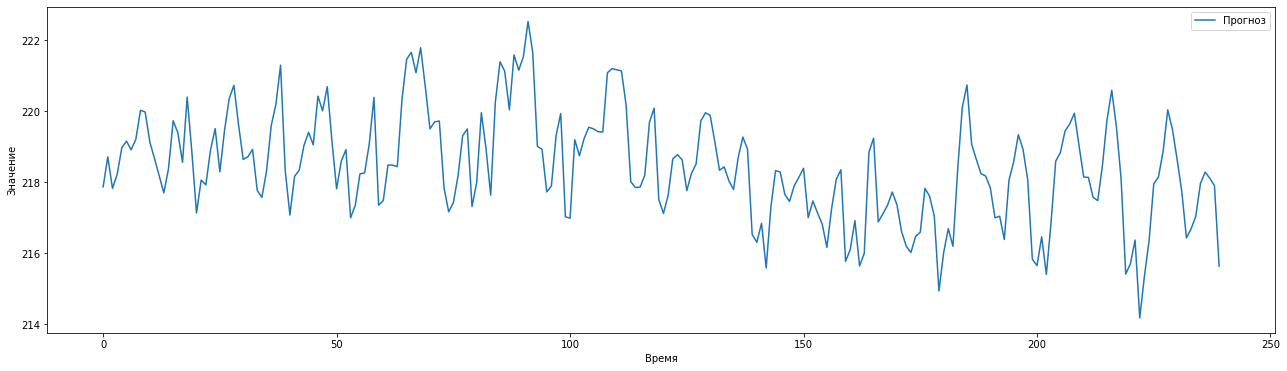

In [261]:
get_inf(model_Night, 3000, 500, X_n, Scaler)

## Сохранение результатов

In [262]:
predictions = model_Day.predict(X_d, verbose=1) 
predictions = Scaler.inverse_transform(predictions)

8/8 [==============================] - 0s 11ms/step


In [263]:
predictions

array([[202.32678],
       [202.54375],
       [202.7655 ],
       [202.37604],
       [201.22633],
       [201.19185],
       [201.7472 ],
       [201.71783],
       [201.2482 ],
       [200.94034],
       [200.46112],
       [200.36346],
       [200.56114],
       [200.3607 ],
       [200.2956 ],
       [200.9646 ],
       [201.37273],
       [201.06409],
       [200.64227],
       [200.976  ],
       [202.49754],
       [202.75784],
       [202.64647],
       [201.79578],
       [201.30052],
       [201.47734],
       [201.73373],
       [201.72511],
       [201.13576],
       [200.554  ],
       [200.2401 ],
       [200.04948],
       [200.33853],
       [200.12093],
       [199.62833],
       [199.78624],
       [200.70616],
       [200.6035 ],
       [199.8592 ],
       [199.59688],
       [200.62218],
       [201.06615],
       [200.9449 ],
       [200.43019],
       [200.38678],
       [200.94876],
       [201.32025],
       [200.71617],
       [199.82767],
       [199.17136],


In [267]:
# получаем выходной набор в виде датафрейма с полями метки времени и значений
submission = pd.DataFrame({'TimeValue':X_test_sub_d['Data_Time_Prognoz'].values[-240:], 'Value':predictions[:,0]}, columns=['TimeValue', 'Value'])
submission.to_csv(path + 'Прогноз_Day_240.csv')

In [121]:
predictions = model_Night.predict(X_n, verbose=1) 
predictions = Scaler.inverse_transform(predictions)

38/38 [==============================] - 0s 5ms/step


In [124]:
predictions

array([[218.56732],
       [219.71637],
       [218.26048],
       ...,
       [217.64215],
       [220.03194],
       [218.67728]], dtype=float32)

In [268]:
# получаем выходной набор в виде датафрейма с полями метки времени и значений
submission = pd.DataFrame({'TimeValue':X_test_sub_n['Data_Time_Prognoz'].values[-240:], 'Value':predictions[:,0]}, columns=['TimeValue', 'Value'])
submission.to_csv(path + 'Прогноз_Night_240.csv')